---
title: 位置情報したい
---

- [pandas.DataFrameからgeopandas.GeoDataFrameに変換する方法](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html)
- ``pd.DataFrame``で位置情報を扱う場合、``geopandas.GeoDataFrame``に変換が必要です。
- ``geopandas.GeoDataFrame``は``pd.DataFrame``のサブクラスです。
- ``geopandas.points_from_xy(緯度のカラム名、経度のカラム名、高度のカラム名)``を使って、該当カラムを``POINT``オブジェクトに変換します。
- ``POINT``オブジェクトに変換するときに、空間座標系を指定する必要があります。GPSの場合は``EPSG:4326``（地理座標系）にしておけばよいようです。

In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import geodatasets
import hvplot.pandas

print(f"Pandas: {pd.__version__}")
print(f"GeoPandas: {gpd.__version__}")
print(f"GeoDataSets: {geodatasets.__version__}")
print(f"HvPlot: {hvplot.__version__}")


Pandas: 2.2.2
GeoPandas: 0.14.3
GeoDataSets: 2023.12.0
HvPlot: 0.9.2


GPSを記録したファイル名を指定します。

In [2]:
read_from = Path("./_static/phyphox/_GPS_2024-04-21_14-00-07/RawData.csv")
read_from.exists()


True

CSVファイルを``pd.DataFrame``として読み込みます。

In [3]:
names = [
    "time",
    "latitude",  # 緯度
    "longitude",  # 経度
    "altitude",  # 高度
    "altitude_wgs84",  # 高度（地理座標系）
    "speed",
    "direction",
    "distance",
    "horizontal_accuracy",
    "vertical_accuracy",
    "satellites",
]

data = pd.read_csv(read_from, names=names, skiprows=1)
len(data)


4596

読み込んだデータフレームを確認します。
緯度、経度、高度がただの数値として読み込まれていることが分かります。
このままでも、位置座標としてプロットできます。

In [4]:
data.head()


,time,latitude,longitude,altitude,altitude_wgs84,speed,direction,distance,horizontal_accuracy,vertical_accuracy,satellites
0,0.002500,35.170524,136.880678,9.436914,48.035872,NaN,NaN,0.002205,202.244157,21.084093,-1.0
1,0.036553,35.170506,136.880689,9.436914,48.035896,NaN,NaN,0.002373,277.518795,21.084093,-1.0
2,0.480972,35.170505,136.880690,9.436914,48.035898,NaN,NaN,0.002374,277.953106,21.084093,-1.0
3,0.483613,35.170505,136.880690,9.436914,48.035898,NaN,NaN,0.262835,277.953121,21.084093,-1.0
4,0.577826,35.168394,136.881933,8.380713,46.982551,NaN,NaN,0.355842,59.856355,21.084093,-1.0


In [5]:
data.hvplot.scatter(x="time", y="latitude")
data.hvplot.scatter(x="time", y="longitude")
data.hvplot.scatter(x="longitude", y="latitude")


:Scatter   [longitude]   (latitude)

In [6]:
data.hvplot.scatter(x="altitude", y="altitude_wgs84")


:Scatter   [altitude]   (altitude_wgs84)

経過時間と移動速度をプロットしてみました。
速度が0になっている場所は、新幹線が停止した駅です。

また、ぽつぽつと`370 km/h`に近いピークがありますが、トンネルなどでGPS情報を受信できない状態が続いたあとで、トンネルから抜けた後の地点です。

In [7]:
data["speed_kmh"] = data["speed"] * 3.6
data.hvplot.scatter(x="time", y="speed_kmh", c="altitude")


:Scatter   [time]   (speed_kmh,altitude)

In [8]:
data.hvplot.scatter(
    x="time",
    y="latitude",
)
data.hvplot.errorbars(x="time", y="latitude", yerr1="horizontal_accuracy")
data.hvplot.errorbars(x="time", y="altitude", yerr1="vertical_accuracy", c="speed_kmh")


:ErrorBars   [time]   (altitude,vertical_accuracy,speed_kmh)

# GeoDataFrameに変換する

- `GeoDataFrame`には`shapely`オブジェクトが必要
- `points_from_xy()`を使って経度／緯度のデータを`shapely.Point`オブジェクトのリストに変換する
- 上で作成したデータを`geometry`に設定する

---

- [geopandas.points_from_xy](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)
- [EPSG:4326](https://epsg.io/4326) : WGS84 / 地理座標系（緯度経度） / GPSで利用される座標系
  - European Petroleum Survey Group（現在 International Association of Oil & Gas Producers)


In [9]:
gps = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(
        data.longitude, data.latitude, data.altitude, crs="EPSG:4326"
    ),
    crs="EPSG:4326",
)
gps


,time,latitude,longitude,altitude,altitude_wgs84,speed,direction,distance,horizontal_accuracy,vertical_accuracy,satellites,speed_kmh,geometry
0,0.002500,35.170524,136.880678,9.436914,48.035872,NaN,NaN,0.002205,202.244157,21.084093,-1.0,NaN,POINT Z (136.88068 35.17052 9.43691)
1,0.036553,35.170506,136.880689,9.436914,48.035896,NaN,NaN,0.002373,277.518795,21.084093,-1.0,NaN,POINT Z (136.88069 35.17051 9.43691)
2,0.480972,35.170505,136.880690,9.436914,48.035898,NaN,NaN,0.002374,277.953106,21.084093,-1.0,NaN,POINT Z (136.88069 35.17050 9.43691)
3,0.483613,35.170505,136.880690,9.436914,48.035898,NaN,NaN,0.262835,277.953121,21.084093,-1.0,NaN,POINT Z (136.88069 35.17050 9.43691)
4,0.577826,35.168394,136.881933,8.380713,46.982551,NaN,NaN,0.355842,59.856355,21.084093,-1.0,NaN,POINT Z (136.88193 35.16839 8.38071)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,5300.182942,35.629216,139.740871,10.102954,47.213599,NaN,NaN,341.243455,57.000000,24.906006,-1.0,NaN,POINT Z (139.74087 35.62922 10.10295)
4592,5319.002434,35.629216,139.740871,10.103572,47.214217,NaN,NaN,341.244553,57.000158,24.906006,-1.0,NaN,POINT Z (139.74087 35.62922 10.10357)
4593,5334.455927,35.629221,139.740861,9.267242,46.377958,NaN,NaN,341.245624,57.000269,19.162832,-1.0,NaN,POINT Z (139.74086 35.62922 9.26724)
4594,5340.455993,35.629226,139.740851,8.916280,46.027065,NaN,NaN,341.275562,57.000287,16.149393,-1.0,NaN,POINT Z (139.74085 35.62923 8.91628)


``geometry``というカラムが追加されています。

<Axes: >

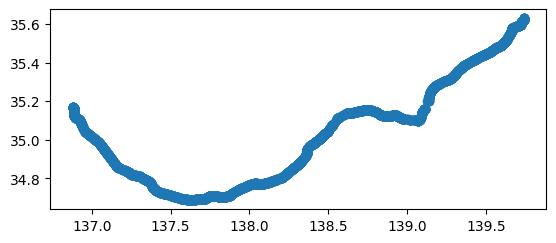

In [10]:
gps.plot()


<Axes: xlabel='longitude', ylabel='latitude'>

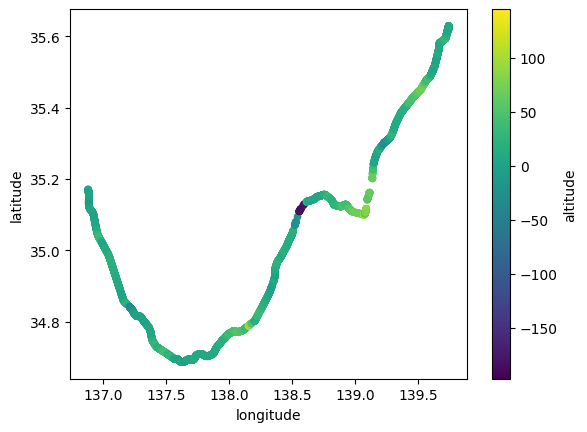

In [11]:
data.plot.scatter(x="longitude", y="latitude", c="altitude")


<Axes: xlabel='longitude', ylabel='latitude'>

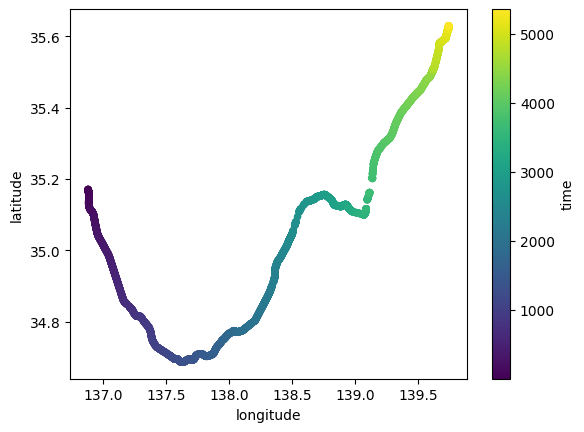

In [12]:
data.plot.scatter(x="longitude", y="latitude", c="time")


In [13]:
# nybb = geodatasets.get_path("nybb")
cities = gpd.datasets.get_path("naturalearth_cities")
geo = gpd.read_file(cities)


/var/folders/6p/jjpn4b1d1fxf36kt1l666ny40000gn/T/ipykernel_35092/257032633.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = gpd.datasets.get_path("naturalearth_cities")


<Axes: >

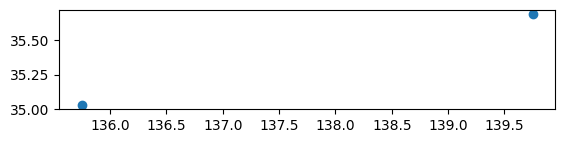

In [14]:
q = "name == 'Tokyo' or name == 'Kyoto'"
geo.query(q).plot()


In [31]:
geo.hvplot(tiles="EsriTerrain")

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]

In [16]:
import cartopy.crs as ccrs


In [21]:
geo.hvplot(
    coastline=True,
    projection=ccrs.Geostationary(central_longitude=-30),
    global_extent=True,
)


:Overlay
   .Points.I    :Points   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]

In [25]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries


/var/folders/6p/jjpn4b1d1fxf36kt1l666ny40000gn/T/ipykernel_35092/4072173014.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


<Axes: >

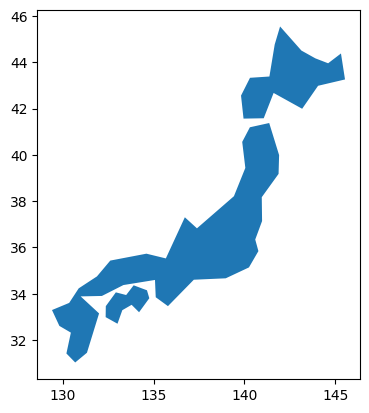

In [40]:
countries.value_counts("continent")
countries.value_counts("name")

q = "name == 'Japan'"


<Axes: xlabel='longitude', ylabel='latitude'>

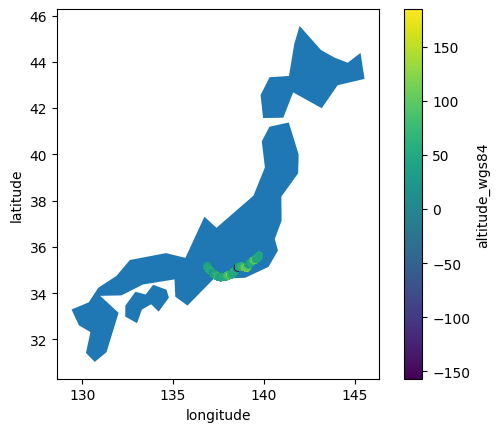

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()

countries.query(q).plot(ax=axs)
gps.plot.scatter(x="longitude", y="latitude", c="altitude_wgs84", ax=axs)